<a href="https://colab.research.google.com/github/FraGoTe/redes-neuronales/blob/master/RxFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MODELOS DE RNA PRE-ENTRENADOS - Fine Tuning - Imágenes Médicas

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0



##Carga de datos
---

Montando archivos:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Mostrando lista de archivos:

In [0]:
%%bash
ls -l /content/drive/My\ Drive/RN_2019II/Sesion12-1

total 215
drwx------ 2 root root   4096 Nov 10 16:18 dataset
drwx------ 2 root root   4096 Nov 10 16:18 model
-rw------- 1 root root 211763 Nov 10 16:24 pretrained_rx_finetuning.ipynb


## VISUALIZACION DE DATA
---

Using TensorFlow backend.


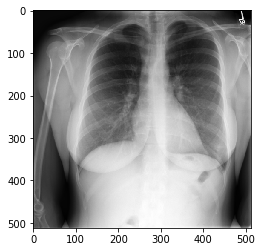

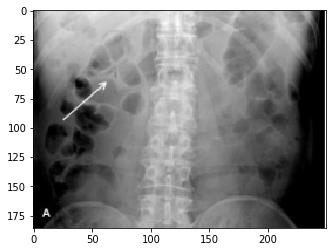

In [0]:
# Cargando dataset, redimensionando y guardando archivos
from keras.preprocessing.image import load_img

main_path = "/content/drive/My Drive/RN_2019II/Sesion12-1/"
# Folders
path_torax = "".join([main_path,"dataset/train/torax/42_IM-2063-1001.png"])
path_abdomen = "".join([main_path,"dataset/train/abdomen/openI_1.png"])

# Mostrar las imágenes de nuestro dataset
import matplotlib.pyplot as plt
img_rx_torax = load_img(path_torax)
img_rx_abdomen = load_img(path_abdomen)

plt.imshow(img_rx_torax)
plt.show()
plt.imshow(img_rx_abdomen)
plt.show()


 ## PARTE I - PREPROCESAMIENTO DE DATOS
---


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Dataset Folder
folder_main_dataset = "".join([main_path,"dataset"])

# Preprocesamiento de imágenes: Definiremos una dimensión de 300x300
img_width = 224
img_height = 224

print("\nDescripción de la data de training:")
# Generador de data
datagen = ImageDataGenerator( rescale = 1.0/255.0,
                              horizontal_flip = True)
# rescale: Normalizar valores [0-1] en lugar de [0-255]
# horizontal_flip: valor booleno. Voltea aleatoriamente las entradas horizontalmente.

training_set = datagen.flow_from_directory(folder_main_dataset + '/train',
                                                 target_size = (img_width, img_height),
                                                 batch_size = 1,
                                                 class_mode = 'binary')

print("\nDescripción de la data de testing:")
testing_set = datagen.flow_from_directory(folder_main_dataset + '/test',
                                                 target_size = (img_width, img_height),
                                                 batch_size = 1,
                                                 class_mode = 'binary')

num_imgs_training = len(training_set.filenames)
num_imgs_testing = len(testing_set.filenames)

print("\n")
print(training_set.class_indices)
print("Número de imágenes de entenamiento: ",num_imgs_training)
print("Número de imágenes de testing: ",num_imgs_testing)


Descripción de la data de training:
Found 65 images belonging to 2 classes.

Descripción de la data de testing:
Found 10 images belonging to 2 classes.


{'abdomen': 0, 'torax': 1}
Número de imágenes de entenamiento:  65
Número de imágenes de testing:  10


---
## PARTE II - CONSTRUYENDO LA RED NEURONAL CONVOLUCIONAL
---

In [0]:
# VGG16
from keras.applications import vgg16

# Cargando modelo VGG
# include_top=False (Sin clasificador)
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
vgg_conv.summary();

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# Freeze todas las capas de Convolución menos 4
# Freeze todas las capas de Convolución menos 
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

vgg_conv.summary();

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# Verificando que las capas convolucionales no sean "entrenables"
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fcc127947f0> False
<keras.layers.convolutional.Conv2D object at 0x7fcc12794710> False
<keras.layers.convolutional.Conv2D object at 0x7fcc127ff6a0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcc125c5898> False
<keras.layers.convolutional.Conv2D object at 0x7fcc12557908> False
<keras.layers.convolutional.Conv2D object at 0x7fcc12551a20> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcc12559780> False
<keras.layers.convolutional.Conv2D object at 0x7fcc125647b8> False
<keras.layers.convolutional.Conv2D object at 0x7fcc12564cc0> False
<keras.layers.convolutional.Conv2D object at 0x7fcc1256ae48> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcc125766a0> False
<keras.layers.convolutional.Conv2D object at 0x7fcc12584710> False
<keras.layers.convolutional.Conv2D object at 0x7fcc12584f60> False
<keras.layers.convolutional.Conv2D object at 0x7fcc12589e48> False
<keras.layers.pooling.MaxPooling2D object at 0x7fcc11d17668>

Arquitectura de la Red Neuronal Artificial final:

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# Definiendo la ARQUITECTURA de la Red Neuronal Convolucional final
model = Sequential()

# Agregando la parte convolucional (base)
model.add(vgg_conv)

# Clasificador
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 17,934,401
Trainable params: 10,299,137
Non-trainable params: 7,635,264
_________________________________________________________________


Entrenamiento:

In [0]:
# COMPILANDO la Red Neuronal Convolucional
#opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# ENTRENANDO la Red
import datetime
print('Iniciando a las: ', datetime.datetime.now())
print("...")

epochs=10
batch_size=2
history = model.fit_generator(training_set, steps_per_epoch=num_imgs_training/batch_size,
                              validation_data=testing_set,
                              validation_steps=num_imgs_testing/batch_size,
                              epochs=epochs)

print("...")
print('Terminando a las: ', datetime.datetime.now())


Iniciando a las:  2019-11-04 19:41:57.785035
...
Epoch 1/10
33/32 [==============================] - 1s 42ms/step - loss: 0.6223 - acc: 0.6667 - val_loss: 0.2109 - val_acc: 0.8000
Epoch 2/10
33/32 [==============================] - 1s 16ms/step - loss: 0.6235 - acc: 0.8182 - val_loss: 0.1829 - val_acc: 1.0000
Epoch 3/10
33/32 [==============================] - 0s 15ms/step - loss: 0.0214 - acc: 1.0000 - val_loss: 1.2351e-05 - val_acc: 1.0000
Epoch 4/10
33/32 [==============================] - 1s 16ms/step - loss: 4.4889e-04 - acc: 1.0000 - val_loss: 0.0568 - val_acc: 1.0000
Epoch 5/10
33/32 [==============================] - 0s 14ms/step - loss: 6.7277e-05 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 1.0000
Epoch 6/10
33/32 [==============================] - 1s 15ms/step - loss: 4.8282e-05 - acc: 1.0000 - val_loss: 1.2311e-05 - val_acc: 1.0000
Epoch 7/10
33/32 [==============================] - 0s 14ms/step - loss: 4.7243e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 8/10

Graficando resultados:

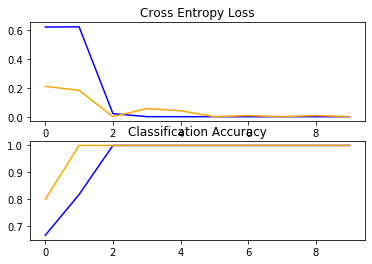

In [0]:
# GRAFICANDO resultados
import matplotlib.pyplot as plt
# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='test')

---
## PARTE III - PREDICCIONES Y EVALUACIONES DE LA RED
---

In [0]:
# EVALUANDO la Red
acc = model.evaluate_generator(testing_set, num_imgs_testing/batch_size)
print('\nValidación:')
print('val_loss %.3f' % (acc[0] * 100.0))
print('val_acc %.3f' % (acc[1] * 100.0))


Validación:
val_loss 3.162
val_acc 100.000


Guardango el modelo en Disco:

In [0]:
# Model folder
folder_main_model = "".join([main_path,"/model"])

# Guardar el modelo en disco
cnn_model_json = model.to_json()
with open("".join([folder_main_model,"/rx_model-ft-vgg.json"]),"w") as json_file:
  json_file.write(cnn_model_json)

model.save_weights("".join([folder_main_model,"/rx_model-ft-vgg.h5"]))
print("Modelo guardado en disco ...")

Modelo guardado en disco ...


Predicción:

Modelo cargado de disco!


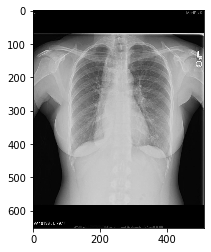

1.0  --> RX de Tórax


In [0]:
# Cargando modelo de disco
from keras.models import model_from_json
import numpy as np

json_file = open("".join([folder_main_model,"/rx_model-ft-vgg.json"]), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("".join([folder_main_model,"/rx_model-ft-vgg.h5"]))
print("Modelo cargado de disco!")


# Testing con una imagen
from keras.preprocessing import image
import matplotlib.pyplot as plt

test_image_path = "".join([folder_main_dataset,"/samples/img2.png"])
test_image = image.load_img(test_image_path)
plt.imshow(test_image)
plt.show()

test_image = image.load_img(test_image_path,target_size = (img_width, img_height))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)


result = loaded_model.predict(test_image)

if result[0][0] == 1:
    print(result[0][0], ' --> RX de Tórax')
else:
    print(result[0][0], ' --> RX de Abdomen')